In [1]:
import os
import math

import torch
import numpy as np
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.heat.heat_diffusion import HeatDiffusion_Revised
from scorefield.models.rrt.rrt import RRTStar
# from scorefield.models.rrt.rrt2 import RRTStar
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, gen_agents, overlay_goal, overlay_multiple, combine_objects, overlay_images,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,

    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors
)

import matplotlib.pyplot as plt

import imageio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


# Args
# config_dir = "./scorefield/configs/heat_diffusion.yaml"
config_dir = "./scorefield/configs/rrt.yaml"

args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']


# u0 = args['u0']
# min_heat_step = args['min_heat_step']
# max_heat_step = args['max_heat_step']
# sample_num = args['sample_num']
# time_type = args['time_type']
# noise_steps = args['noise_steps']

# diffusion = HeatDiffusion_Revised(
#     image_size=img_size,
#     u0 = u0,
#     noise_steps=noise_steps,
#     min_heat_step=min_heat_step,
#     max_heat_step=max_heat_step,
#     time_type=time_type,
#     device=device,
# )

delta_dist = args['delta_dist']
radius = args['radius']
max_iters = args['max_iters']
time_steps = args['time_steps']

rrt = RRTStar(
    image_size=img_size,
    time_steps=time_steps,
    delta_dist=delta_dist,
    radius=radius,
)
# rrt = RRTStar()


/home/mlcs_edf/mambaforge/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
obstacle_masks = convert_to_obstacle_masks(2, bg.size, img_size, obstacle_pos)
# obstacle_masks = randgen_obstacle_masks(1, img_size)
background = draw_obstacles_pixel(bg, obstacle_masks)
# goal = torch.tensor([[[0.7,-0.7]]], device=device)
# initials = torch.tensor([[[-0.3, -0.7]]], device=device)
goal = gen_goals(goal_bounds, 2, img_size, obstacles=obstacle_masks)
initials = gen_agents(goal_bounds, (5,2), img_size, obstacles=obstacle_masks)
obs = overlay_goal(background, img_size, wastes, goal)
t = torch.tensor([i for i in range(1, time_steps+1)], device=device)

paths, delta = rrt.plan(starts=initials, goals=goal, obstacle_masks=obstacle_masks, max_iters=5000)
# paths = rrt.run(starts=initials, goals=goal, obstacle_masks=obstacle_masks)

result_img = overlay_goal_agent(background, wastes, goal.cpu(), torch.tensor(paths[0][0]).unsqueeze(0).cpu(), 1)
plt.imshow(result_img[0])
plt.show()
result_img = overlay_goal_agent(background, wastes, goal.cpu(), torch.tensor(paths[0][4]).unsqueeze(0).cpu(), 1)
plt.imshow(result_img[0])
plt.show()

torch.Size([2, 5, 2]) torch.Size([2, 1, 2]) torch.Size([2, 64, 64])
2


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [8]:
obstacle_masks.shape

torch.Size([2, 64, 64])

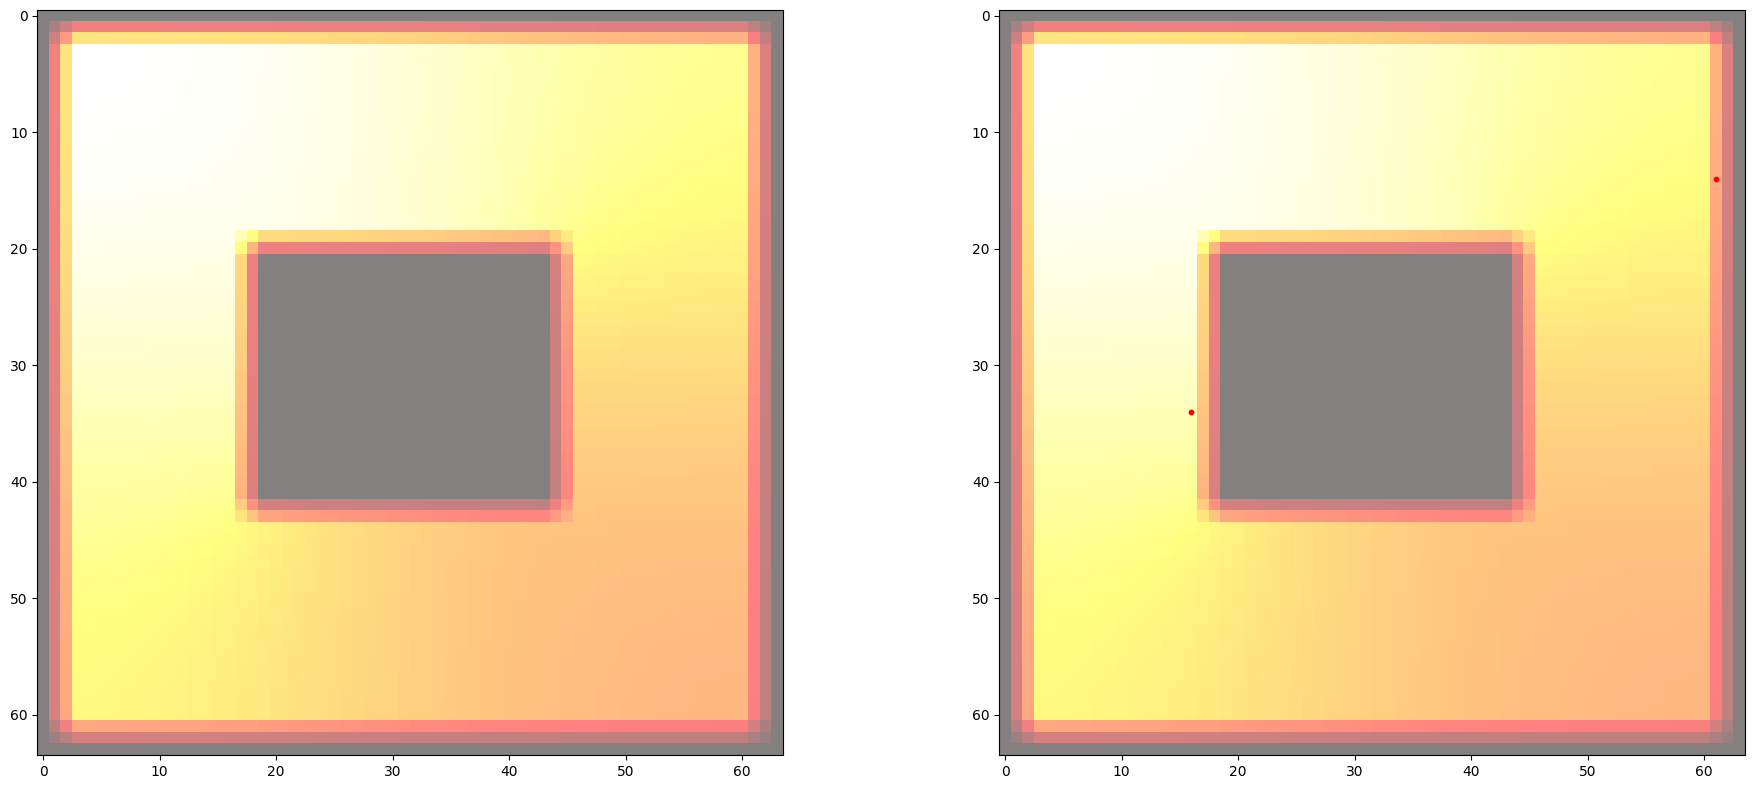

In [5]:
i = 7
# print(score_field.shape)
# print(score.shape)
# norm_score = score_field * diffusion.std.view(score.size(0), 1, 1, 1)

# data = norm_score[i]
# V = data[...,0]
# U = data[...,1]

# V_clip, U_clip = clip_vectors(V, U, 0.01)
# # V_clip, U_clip = V, U
# x, y = np.meshgrid(np.linspace(0, img_size-1, img_size), np.linspace(0,img_size-1,img_size))

fig, axes = plt.subplots(1, 2, figsize=(20,8))

heat_viz = heat[i]
log_heat_viz = torch.log(heat_viz+1e-9)
log_heat_viz = log_heat_viz - log_heat_viz.min()
samples = (xt[i]+1) * 0.5 * (img_size-1)

axes[0].imshow(heat_viz.cpu().detach().numpy(), cmap='hot', origin='upper',interpolation='nearest', alpha=0.5)#, vmax=heat[i].max()*0.0005)
# axes[1].quiver(x, y, U_clip.cpu().numpy(), V_clip.cpu().numpy(), angles='xy', scale_units='xy', scale=0.01)
# axes[1].invert_yaxis()

axes[1].imshow(heat_viz.detach().cpu().numpy(), cmap='hot', origin='upper',interpolation='nearest', alpha=0.5)
axes[1].scatter(samples[:, 1].detach().cpu().numpy(), samples[:, 0].detach().cpu().numpy(), c='red', s=10)

plt.tight_layout()
plt.show()

In [ ]:
scale = 0.5

B = heat.shape[0]

scale=10

fig = make_subplots(rows=1, cols=1, subplot_titles=("Heat Distribution"))

# Add initial data
fig.add_trace(go.Heatmap(z=heat[0].cpu().numpy(), colorscale='Viridis', showscale=False), row=1, col=1)

for i in range(img_size):
    for j in range(img_size):
        fig.add_trace(
            go.Scatter(x=[x[i,j], x[i,j] + scale * u[i,j]],
                       y=[y[i,j], y[i,j] - scale * v[i,j]],  # subtracting to account for the typical display where the top left is (0,0)
                       mode='lines',
                       line=dict(color='blue', width=0.5),
                       showlegend=False),
            row=1, col=2)

fig.update_yaxes(autorange="reversed", row=1, col=1)


fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Batch:',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [
            {
                'args': [
                    [frame['name']],
                    {
                        'frame': {'duration': 300, 'redraw': True},
                        'mode': 'immediate'
                    }
                ],
                'label': frame['name'],
                'method': 'animate'
            } for frame in frames
        ]
    }]
)

fig.update_layout(
    width=1600,
    height=800,
)

fig.update_yaxes(scaleanchor="x", scaleratio=1, row=1, col=1)
fig.update_yaxes(autorange="reversed", row=1, col=1)

fig.show()
